# references
1. https://www.kaggle.com/columbia2131/device-eda-interpolate-by-removing-device-en-ja

# Load Libraries

In [2]:
import numpy as np
import pandas as pd
from glob import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import plotly.express as px
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
notebookName = 'Baseline'
PATH = Path(f"./models/{notebookName}")

In [5]:
if os.path.isdir(PATH):
    dir_list = os.listdir(PATH)
    num_files = 0
    while True:
        if os.path.isfile(str(PATH / f"{num_files}")):
            print(num_files)
            num_files += 1
        else:
            break
else:
    os.mkdir(PATH)
    num_files = 0

0
1
2
3


In [6]:
num_files

4

In [7]:
RANDOM_STATE = 1990
lr = 0.0005
batch_size = 128
EPOCH_NUM = 1000

torch.manual_seed(RANDOM_STATE)

experience_name = f"{num_files}"
checkpoint_name = "check_point"
model_name = str("model - " + experience_name)
param_name = str("param - " + experience_name)
result_name = str("result - " + experience_name)

dummy_path = str(PATH / f"{num_files}")
checkpoint_path = str(PATH / f"{checkpoint_name}.pth")
model_path = str(PATH / f"{model_name}.pth")
param_path = str(PATH / f"{param_name}.pth")
result_path = str(PATH / f"{result_name}.csv")
model_path, param_path, result_path

('models\\Baseline\\model - 4.pth',
 'models\\Baseline\\param - 4.pth',
 'models\\Baseline\\result - 4.csv')

# Useful Functions

In [8]:
def calc_haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    
    c = 2 * np.arcsin(a ** 0.5)
    dist = 6_367_000 * c
    return dist

In [9]:
def check_score(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = input_df.copy()
    
    output_df['meter'] = input_df.apply(
        lambda r: calc_haversine(
            r.latDeg, r.lngDeg, r.t_latDeg, r.t_lngDeg
        ),
        axis=1
    )

    meter_score = output_df['meter'].mean()
    print(f'error meter: {meter_score}')

    scores = []
    for phone in output_df['phone'].unique():
        _index = output_df['phone']==phone
        p_50 = np.percentile(output_df.loc[_index, 'meter'], 50)
        p_95 = np.percentile(output_df.loc[_index, 'meter'], 95)
        scores.append(p_50)
        scores.append(p_95)

    score = sum(scores) / len(scores)
    print(f'score: {score}')
    
    return output_df, meter_score , score

In [10]:
def check_score_np(predict:torch.Tensor, target:torch.Tensor):
    m = []
    predict = predict.detach().numpy()
    target = target.detach().numpy()
    for i in range(predict.shape[0]):
        temp = calc_haversine(predict[i,0], predict[i,1], target[i,0], target[i,1])
        m.append(temp)
    
    m = np.array(m)
    score = (np.percentile(m, 50) + np.percentile(m, 95))/2
    
    return score

# Load Datasets

In [102]:
data_dir = Path("../input/google-smartphone-decimeter-challenge")
df_train = pd.read_pickle(str(data_dir / "gsdc_train.pkl.gzip"))

In [12]:
# check score
df_train, default_loss, default_meas = check_score(df_train)

error meter: 3.84684837499064
score: 5.2879706490841585


# Feature Engineering
## Simple view, what is in data frame.

In [13]:
print(df_train.shape)
df_train.head()

(131342, 111)


,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,utcTimeMillis_x,elapsedRealtimeNanos_x,UncalGyroXRadPerSec,...,ySatVelMps,zSatVelMps,satClkBiasM,satClkDriftMps,rawPrM,rawPrUncM,isrbM,ionoDelayM,tropoDelayM,meter
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4,1.589494e+12,1.965654e+13,-0.000502,...,156.040,3559.757,-468.084,0.001,2.379498e+07,11.992,1134.758,10.866,16.647,3.586842
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,1.589494e+12,1.965754e+13,-0.003537,...,411.162,-3013.649,65954.431,-0.002,2.592442e+07,3.897,-222.675,7.111,5.174,2.745901
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4,1.589494e+12,1.965854e+13,0.002028,...,-2776.605,-434.445,1223.261,0.000,2.131445e+07,1.499,0.000,4.777,3.371,1.888409
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4,1.589494e+12,1.965954e+13,-0.015753,...,411.755,-3013.528,65954.426,-0.002,2.592544e+07,3.598,-220.611,7.113,5.183,1.213483
4,2020-05-14-US-MTV-1,Pixel4XLModded,1273529466449,37.423574,-122.094137,-33.20,2020-05-14-US-MTV-1_Pixel4XLModded,1.589494e+12,1.734189e+13,0.875268,...,-81.334,-3057.885,-3909.257,0.001,2.318871e+07,10.493,0.000,7.313,5.311,0.664080


In [14]:
for col in df_train.columns:
    print(col)

collectionName
phoneName
millisSinceGpsEpoch
latDeg
lngDeg
heightAboveWgs84EllipsoidM
phone
utcTimeMillis_x
elapsedRealtimeNanos_x
UncalGyroXRadPerSec
UncalGyroYRadPerSec
UncalGyroZRadPerSec
DriftXRadPerSec
DriftYRadPerSec
DriftZRadPerSec
utcTimeMillis_y
elapsedRealtimeNanos_y
UncalMagXMicroT
UncalMagYMicroT
UncalMagZMicroT
BiasXMicroT
BiasYMicroT
BiasZMicroT
utcTimeMillis_x
TimeNanos
LeapSecond
TimeUncertaintyNanos
FullBiasNanos
BiasNanos
BiasUncertaintyNanos
DriftNanosPerSecond
DriftUncertaintyNanosPerSecond
HardwareClockDiscontinuityCount
Svid_x
TimeOffsetNanos
State
ReceivedSvTimeNanos
ReceivedSvTimeUncertaintyNanos
Cn0DbHz_x
PseudorangeRateMetersPerSecond
PseudorangeRateUncertaintyMetersPerSecond
AccumulatedDeltaRangeState
AccumulatedDeltaRangeMeters
AccumulatedDeltaRangeUncertaintyMeters
CarrierFrequencyHz_x
CarrierCycles
CarrierPhase
CarrierPhaseUncertainty
MultipathIndicator
SnrInDb
ConstellationType_x
AgcDb
BasebandCn0DbHz_x
FullInterSignalBiasNanos
FullInterSignalBiasUncertai

WTF.. 총 컬럼의 개수가 총 111개나 된다. 물론 이는 중복된 값도 여럿 존재하고, 의미없는 수치가 포함된 결과이기도 해서 온전히 받아들일 수 없긴 하지만.. 그래도 너무 많다.

## Is There Null?
데이터 사이의 공백이 얼마나 있는지 우선 확인해보자.

In [103]:
df_train.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131342 entries, 0 to 131341
Data columns (total 110 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   collectionName                             131342 non-null  object 
 1   phoneName                                  131342 non-null  object 
 2   millisSinceGpsEpoch                        131342 non-null  int64  
 3   latDeg                                     131342 non-null  float64
 4   lngDeg                                     131342 non-null  float64
 5   heightAboveWgs84EllipsoidM                 131342 non-null  float64
 6   phone                                      131342 non-null  object 
 7   utcTimeMillis_x                            113798 non-null  float64
 8   elapsedRealtimeNanos_x                     113798 non-null  float64
 9   UncalGyroXRadPerSec                        113798 non-null  float64
 10  UncalGy

중간중간 아무것도 존재하지 않는 데이터도 있고, 빈 데이터가 다수 차지하는 것도 많다. 우선 데이터가 하나도 없는 것들은 모두 제거하고, 공백데이터가 몇퍼센트 존재하는지부터 확인해보자.

In [104]:
df_train = df_train.dropna(axis = 1, how = 'all')
print(df_train.shape)
print(df_train.columns)
df_train.head()

(131342, 105)
Index(['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg',
       'lngDeg', 'heightAboveWgs84EllipsoidM', 'phone', 'utcTimeMillis_x',
       'elapsedRealtimeNanos_x', 'UncalGyroXRadPerSec',
       ...
       'xSatVelMps', 'ySatVelMps', 'zSatVelMps', 'satClkBiasM',
       'satClkDriftMps', 'rawPrM', 'rawPrUncM', 'isrbM', 'ionoDelayM',
       'tropoDelayM'],
      dtype='object', length=105)


,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,utcTimeMillis_x,elapsedRealtimeNanos_x,UncalGyroXRadPerSec,...,xSatVelMps,ySatVelMps,zSatVelMps,satClkBiasM,satClkDriftMps,rawPrM,rawPrUncM,isrbM,ionoDelayM,tropoDelayM
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4,1.589494e+12,1.965654e+13,-0.000502,...,-325.826,156.040,3559.757,-468.084,0.001,2.379498e+07,11.992,1134.758,10.866,16.647
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,1.589494e+12,1.965754e+13,-0.003537,...,-28.481,411.162,-3013.649,65954.431,-0.002,2.592442e+07,3.897,-222.675,7.111,5.174
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4,1.589494e+12,1.965854e+13,0.002028,...,145.957,-2776.605,-434.445,1223.261,0.000,2.131445e+07,1.499,0.000,4.777,3.371
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4,1.589494e+12,1.965954e+13,-0.015753,...,-28.279,411.755,-3013.528,65954.426,-0.002,2.592544e+07,3.598,-220.611,7.113,5.183
4,2020-05-14-US-MTV-1,Pixel4XLModded,1273529466449,37.423574,-122.094137,-33.20,2020-05-14-US-MTV-1_Pixel4XLModded,1.589494e+12,1.734189e+13,0.875268,...,514.269,-81.334,-3057.885,-3909.257,0.001,2.318871e+07,10.493,0.000,7.313,5.311


5개의 컬럼들이 missing value로 채워져 있어 제거 되었다.

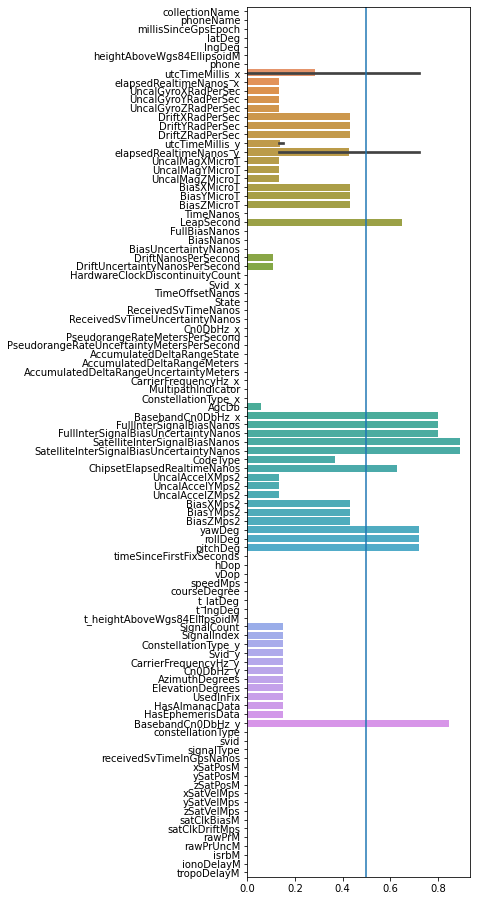

In [105]:
fig = plt.figure(figsize = (4, 16))
ax = plt.gca()
df = df_train.isna().mean(axis = 0)
sns.barplot(x = df, y = df.index, ax = ax)
ax.axvline(0.5)

꽤 많은 데이터들이 공백 데이터가 있지만, 50%를 넘는 경우는 11개, 30%를 넘는 경우는 22개이다. 30%이상 공백 데이터가 있는 경우는 추정하기 어려울 것으로 생각되어, 모두 제거한다.

In [106]:
df_train = df_train.drop(df_train.columns[df_train.isna().mean() > 0.5], axis = 1)
print(df_train.shape)
print(df_train.columns)
df_train.head()

(131342, 89)
Index(['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg',
       'lngDeg', 'heightAboveWgs84EllipsoidM', 'phone',
       'elapsedRealtimeNanos_x', 'UncalGyroXRadPerSec', 'UncalGyroYRadPerSec',
       'UncalGyroZRadPerSec', 'DriftXRadPerSec', 'DriftYRadPerSec',
       'DriftZRadPerSec', 'utcTimeMillis_y', 'UncalMagXMicroT',
       'UncalMagYMicroT', 'UncalMagZMicroT', 'BiasXMicroT', 'BiasYMicroT',
       'BiasZMicroT', 'TimeNanos', 'FullBiasNanos', 'BiasNanos',
       'BiasUncertaintyNanos', 'DriftNanosPerSecond',
       'DriftUncertaintyNanosPerSecond', 'HardwareClockDiscontinuityCount',
       'Svid_x', 'TimeOffsetNanos', 'State', 'ReceivedSvTimeNanos',
       'ReceivedSvTimeUncertaintyNanos', 'Cn0DbHz_x',
       'PseudorangeRateMetersPerSecond',
       'PseudorangeRateUncertaintyMetersPerSecond',
       'AccumulatedDeltaRangeState', 'AccumulatedDeltaRangeMeters',
       'AccumulatedDeltaRangeUncertaintyMeters', 'CarrierFrequencyHz_x',
       'MultipathIndica

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,elapsedRealtimeNanos_x,UncalGyroXRadPerSec,UncalGyroYRadPerSec,...,xSatVelMps,ySatVelMps,zSatVelMps,satClkBiasM,satClkDriftMps,rawPrM,rawPrUncM,isrbM,ionoDelayM,tropoDelayM
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4,1.965654e+13,-0.000502,-0.016050,...,-325.826,156.040,3559.757,-468.084,0.001,2.379498e+07,11.992,1134.758,10.866,16.647
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,1.965754e+13,-0.003537,0.013521,...,-28.481,411.162,-3013.649,65954.431,-0.002,2.592442e+07,3.897,-222.675,7.111,5.174
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4,1.965854e+13,0.002028,0.005823,...,145.957,-2776.605,-434.445,1223.261,0.000,2.131445e+07,1.499,0.000,4.777,3.371
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4,1.965954e+13,-0.015753,0.016050,...,-28.279,411.755,-3013.528,65954.426,-0.002,2.592544e+07,3.598,-220.611,7.113,5.183
4,2020-05-14-US-MTV-1,Pixel4XLModded,1273529466449,37.423574,-122.094137,-33.20,2020-05-14-US-MTV-1_Pixel4XLModded,1.734189e+13,0.875268,1.288668,...,514.269,-81.334,-3057.885,-3909.257,0.001,2.318871e+07,10.493,0.000,7.313,5.311


... 그래도 80개의 컬럼이 남아있다. 이제부턴 차근차근 하나씩 분석해 보자!

## `collectionName` & `phoneName`
`collectionName` 과 `phoneName`은 데이터를 다룰때 하나의 중요한 단서가 될 것 같다. 이 GPS데이터셋은 시계열 데이터일 가능성이 큰데, 날짜와 핸드폰 종류로 구분된 시계열 데이터인 것 같다. 그렇다면, 각 데이터의 길이가 얼마나 되는지 확인해 볼 필요가 있고, 또한 시계열 데이터가 맞는지 확인하기 위해 `millisSinceGpsEpoch`를 확인해서 규칙적으로 분포하는 시계열 데이터인지, 불규칙하게 분포한 시계열 데이터 인지, 시계열 데이터가 아닌지 확인해볼 필요가 있을 것 같다.

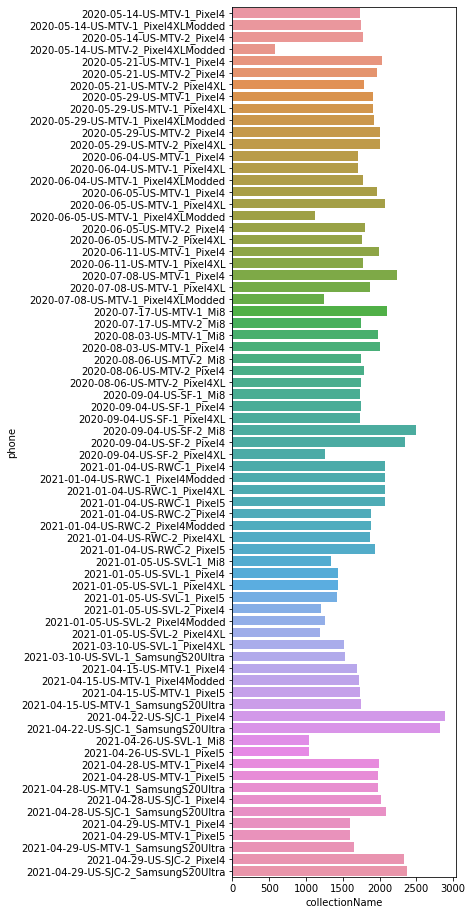

In [107]:

data = df_train.groupby('phone').count()['collectionName']

fig = plt.figure(figsize = (4, 16))
ax = plt.gca()
df = df_train.isna().mean(axis = 0)
sns.barplot(x = data, y = data.index, ax = ax)
ax.axvline(0.5)


In [108]:
data.describe()

count      73.000000
mean     1799.205479
std       383.524552
min       577.000000
25%      1699.000000
50%      1791.000000
75%      2003.000000
max      2890.000000
Name: collectionName, dtype: float64

Confidence Interval 25% ~ 75%의 값을 기준으로 1700~2000개 정도의 길이인 데이터들로 확인된다. 또한 가장 적은 데이터는 577개이고, 가장 많은 데이터는 2890개이다.

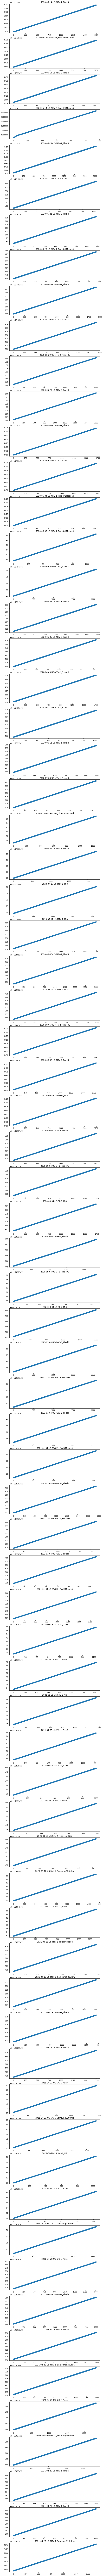

In [110]:
phones = df_train['phone'].unique()
fig, axes = plt.subplots(len(phones), 1, figsize = (10, 4 * len(phones)))
for i, phone in enumerate(phones):
    temp = df_train[df_train['phone'] == phone]
    
    axes[i].plot(range(temp.shape[0]), temp['millisSinceGpsEpoch'],'o')
    axes[i].set_title(phone)
    
plt.show()

`2020-05-14-US-MTV-2_Pixel4XLModded` 를 제외한 나머지 데이터들은 순차적으로 획득한 정보로 보인다. 즉, 모든 정보를 순차적으로 획득한 시계열 데이터라고 생각하여도 크게 다르지 않을 것이라는 예상을 할 수 있다.
따라서 학습이나 추론을 위해 데이터를 변형을 해야 한다면, `phone` 칼럼으로 구분된 시계열 데이터임을 인지 하고 단위를 잘 쪼개 넣어야 할 것 같다.

## `latDeg` & `lngDeg`
`latDeg`와 `lngDeg`는 GPS신호의 위도와 경도를 의미하는 변수이다. 또한 GoogleSmartphoneDecimalChallenge에서 직접 추정해야 하는 변수이기도 하다. 따라서 이 데이터가 어떻게 되어 있는지 확인하는 작업도 중요할 것으로 보인다.
물론 다른 캐글러의 정보를 확인하는 것이 더 빠르기 때문에 우선은 넘어간다!

## `UncalGyroXRadPerSec`, `UncalGyroYRadPerSec`, `UncalGyroZRadPerSec`, `DriftXRadPerSec`, `DriftYRadPerSec`, `DriftZRadPerSec`

* `UncalGyro[X/Y/Z]RadPerSec`는 실제 스마트폰 기기의 움직임과 관련이 있는 변수로 캐글 공식 대회에 나온 데이터 설명은 다음과 같다.즉 drift에 대한 보상이 없이 계산된 X, Y, Z축 방향의 각속도를 의미한다. 각속도는 실제 물체의 움직임의 방향을 예측하는데 큰 도움을 줄 수 있는 변수로 예상 된다.
* `Drift[X/Y/Z]RadPerSec`는 UncalGyro데이터의 드리프트값을 추정한 결과이다. 이 데이터에 포함된 공백 데이터는 이전 날짜에 수집된 정보이다.

In [111]:
phones = df_train['phone'].unique()

0
1
2
3
4
5
6
7


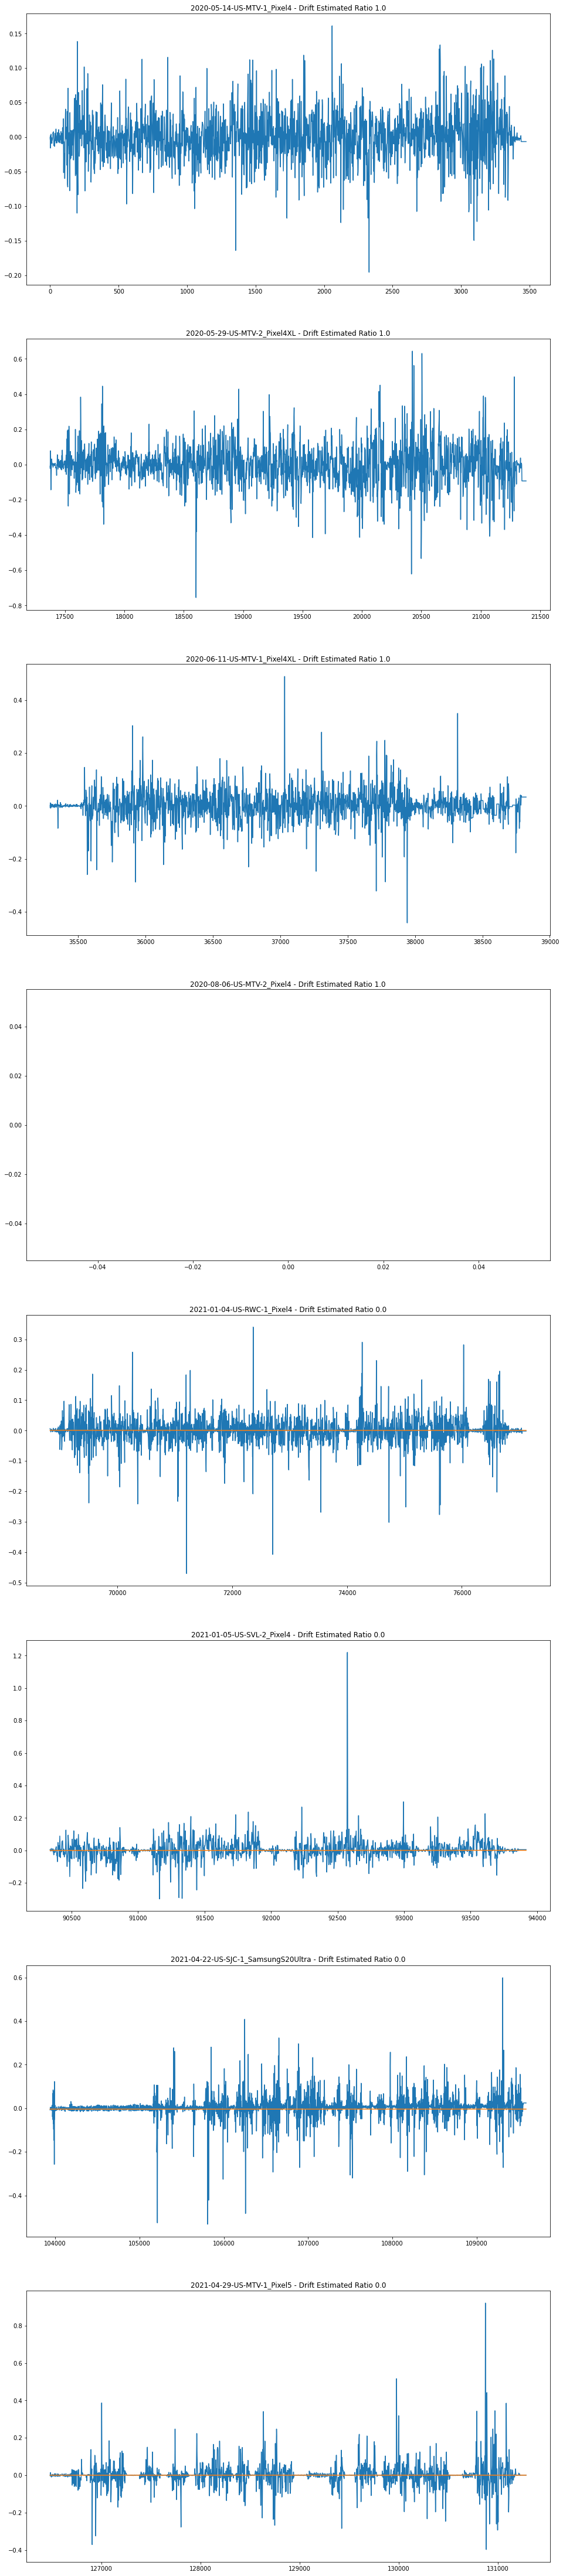

In [130]:
fig, axes = plt.subplots(8, 1, figsize = (16,80))

count = 0
for i, phone in enumerate(phones):
    if i % 10 != 0:
        continue
    temp = df_train[df_train['phone'] == phone]
    count = i//10
    axes[count].plot(temp['UncalGyroXRadPerSec'])
    axes[count].plot(temp['DriftXRadPerSec'])
    axes[count].set_title(f"{phone} - Drift Estimated Ratio {temp['DriftXRadPerSec'].isna().mean()}")
    


특정 데이터셋에서 데이터가 사라지는 문제가 있는 것으로 확인됨.
또한 `DriftXRadPerSec`의 경우에는 특정 시점 데이터 이후에서 나타나는 것으로 보임.

<AxesSubplot:xlabel='UncalGyroZRadPerSec', ylabel='Count'>

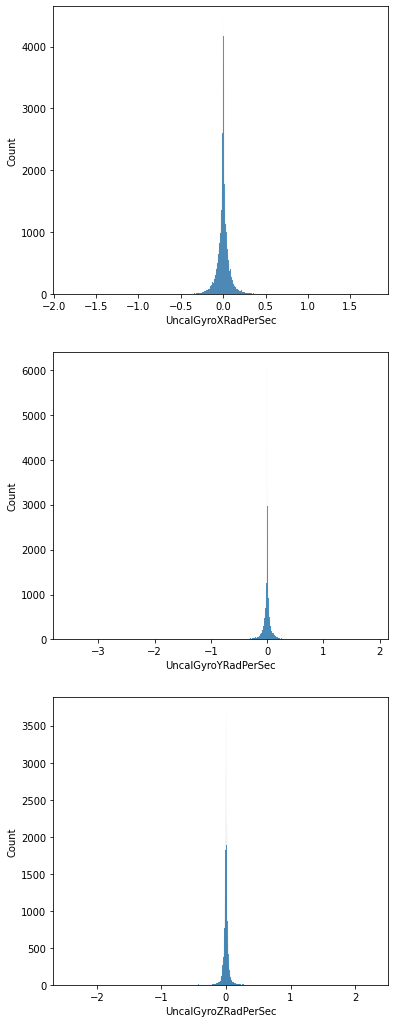

In [70]:
fig, axes = plt.subplots(3, 2, figsize = (6, 18))

sns.histplot(df_train['UncalGyroXRadPerSec'], ax = axes[0])
sns.histplot(df_train['UncalGyroYRadPerSec'], ax = axes[1])
sns.histplot(df_train['UncalGyroZRadPerSec'], ax = axes[2])